In [3]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../../..')))

In [4]:
import numpy as np
factorial = np.math.factorial
import matplotlib.pyplot as plt
import scipy.interpolate
import time 
import copy

# custom modules
import Surrogates.PolynomialChaosExpansion as PCE

from Models.Chaboche_Model.ChabocheModel import ChabocheModel
from Models.Chaboche_Model.ChabocheModel import chaboche_samples
from Models.Chaboche_Model.ChabocheModel import chaboche_uniform_isoprob_monotonic_transform
from Models.Chaboche_Model.ChabocheModel import generate_model_evaluations

# Model Evaluations

$\sigma(t; \, E, \sigma_{y|0}, Q_{iso}, b_{iso}, n_{iso}, D_{iso}, Q_{kin}, b_{kin} ;  \, \dot{\varepsilon}, \nu)$

## 8 Random Variables

($\nu$ if fixed to 0.3)

1. Young's Modulus: $E$

2. Initial Yield Limit: $\sigma_{y|0}$

### Isotropic Parameters

3. Isotropic Asympotote: $Q_{iso}$

4. Isotropic growth rate: $b_{iso}$

5. Isotrpic exponent: $n_{iso}$

6. Isotropic threshold: $D_{iso}$

### Kinematic Parameters

7. Kinematic Asympotote: $Q_{kin}$

8. Kinematic growth rate: $b_{kin}$



# Monotonic Loading

In [9]:
number_of_realizations = 2500
t_min = 0
t_max = 2
delta_t = 1e-3 # time step
n_t = int((t_max-t_min)/delta_t)

max_strain = 5e-2
time_to_max_strain = 1

model = ChabocheModel('1D', 'monotonic', max_strain, time_to_max_strain)

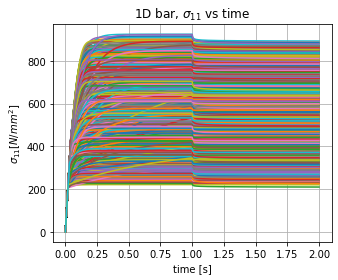

In [10]:
# store samples of parameters
# each row contains 1 set of parameters
SampleSpace = chaboche_samples(number_of_realizations) # [number_of_realizations, 8] matrix

# For monotonic loading
# set b_kin and Q_kin to 0
SampleSpace[:, 6] = 0 # set Q_kin to 0
SampleSpace[:, 7] = 0 # set b_kin to 0

func_evaluations = generate_model_evaluations(model, t_min, t_max, delta_t, 'implicit', SampleSpace, parallel_computation = True)

# plot solution corresponding to each set of random variable
model.stress_plot(t_min, t_max, delta_t, func_evaluations)

# Variance vs time

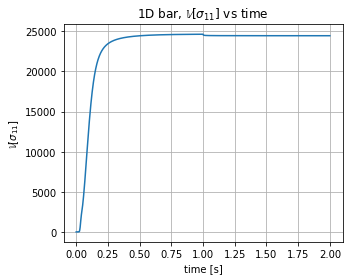

In [13]:
T = np.linspace(t_min, t_max, n_t+1)

fig, ax = plt.subplots(figsize=(5,4))

ax.plot(T, np.var(func_evaluations, axis=1))

ax.set_title(r'1D bar, $\mathbb{V}[\sigma_{11}]$ vs time')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\mathbb{V}[\sigma_{11}]$')
ax.grid()

# Gauß-Legendre Quadrature

Exactly integrates polynomial of degree: 2*number_of_quadrature_points-1

numpy package has been tested upto 100 points

In [14]:
def GaussLegendreQuadrature(lowerlimit, upperlimit, number_of_quadrature_points):

    # numpy method that provides Gauß-Legendre quadrature points and weights 
    quad_points, quad_weights = np.polynomial.legendre.leggauss(number_of_quadrature_points)

    # scaling for change of interval from [-1, 1] to [a, b]
    quad_points = ( (upperlimit-lowerlimit)/2 ) * quad_points + ( (upperlimit+lowerlimit)/2 )
    quad_weights = ( (upperlimit-lowerlimit)/2 ) * quad_weights 

    return quad_points, quad_weights

## Interpolation at Quadrature Points

In [17]:
# Numerical integration in time: T = [0, 100]
number_quad_points = 50
n_t = int((t_max-t_min)/delta_t)
quad_time_points, quad_weights = GaussLegendreQuadrature(t_min, t_max, number_quad_points)

Quad_coord_weight_matrix = np.hstack((quad_time_points.reshape([-1, 1]), quad_weights.reshape([-1, 1])))

# Interpolation 
x_interpolate = np.linspace(t_min, t_max, n_t+1) # time

# store evaluated values at quadrature points
f_at_quad_points = np.zeros((number_of_realizations, number_quad_points))

for i in range(number_of_realizations):

    y_interpolate = func_evaluations.T[i,:]

    f_approximate = scipy.interpolate.interp1d(x_interpolate, y_interpolate, kind='cubic') # create callable from class scipy.interpolate

    f_at_quad_points[i, :] = f_approximate(quad_time_points) # use interpolation function returned by `interp1d`

## Plot of interpolated values at quadrature points

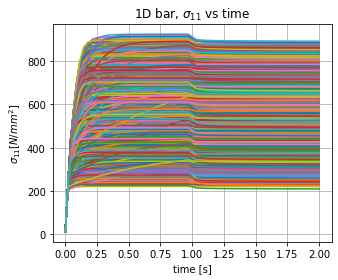

In [18]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(quad_time_points, f_at_quad_points.T)

ax.set_title(r'1D bar, $\sigma_{11}$ vs time')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\sigma_{11} [N/mm^2]$')
ax.grid()

plt.show()

In [19]:
class KLE_PCE_surrogate(PCE.PCE_surrogate):
    
    # Inherit from class PCE_surrogate from PolynomialChaosExpansion module

    '''
    Inputs:
    
        SampleSpace : Samples of random variables [N, N_p]
        
        n_kl : truncation level of KL-expansion
        
        n : total polynomial order
        
        func_vals : evaluated values of eigen_modes 
                    using which surrogate must be constructed [N x n_kl]
        
        eig_values : eigenvalues of the covariance operator
        
    
    Outputs:
    
        Generalised Sobol indices : [N_p, 1]
                                    history-aware index @ t = T of all random variables
    
    '''

    def __init__(self, X, func_evals_at_quadpoints, quad_weights, total_polynomial_degree, polynomial_classes_of_random_variables, n_kl, isoprob_transform):

        self.X = X
        self.N = X.shape[0]
        self.func_evals_at_quadpoints = func_evals_at_quadpoints
        self.quad_weights = quad_weights
        self.n = total_polynomial_degree
        self.pcrv = polynomial_classes_of_random_variables 
        self.N_p = len(self.pcrv)
        self.n_kl = n_kl
        self.isoprob_transform = isoprob_transform

        # set classes of random variables
        for i in range(self.N_p):
            
            if self.pcrv[i] == 'Hermite':
                self.pcrv[i] = PCE.Hermite

            if self.pcrv[i] == 'Legendre':
                self.pcrv[i] = PCE.Legendre

        # total number of polynomial terms in the PCE
        self.number_of_PCE_terms = int (factorial(self.N_p+self.n) / ( factorial(self.N_p) * factorial(self.n) ))

        # compute all permutations of monomials which have total degree <= n
        self.all_permutations, self.comb_dict = PCE.compute_all_permutations(self.n, self.N_p)

    def compute_covariance_matrix(self):

        Y = copy.deepcopy(self.func_evals_at_quadpoints)

        Y_mean = np.mean(Y, axis=0) # compute mean at each (t_i)

        # center the process
        self.Y_c = Y-Y_mean

        # convert quad_weights vector to diagonal matrix
        self.quad_weights_diag = np.diag(self.quad_weights)

        # find square root of weights
        self.sqrt_quad_weights = np.sqrt(self.quad_weights_diag)

        # Covariance matrix
        # size: [N_quad, N_quad]
        # unbiased estimator: 1/(N-1)
        C = (1/(self.N-1))*np.dot(self.Y_c.T, self.Y_c)

        # Pre and post multiply covariance matrix with
        # square root of quadrature weights
        K = self.sqrt_quad_weights @ C @ self.sqrt_quad_weights

        return K

    def eigenvalues_covariance_matrix(self):

            K = self.compute_covariance_matrix()

            # Eigenvalue Decomposition
            eig_values, eig_vectors = np.linalg.eig(K)

            # Compute true eigenvectors
            self.weighted_eig_vectors = np.linalg.inv(self.sqrt_quad_weights) @ eig_vectors

            # Discard imaginary part, as eigenvalues are real
            eig_values = np.real(eig_values)

            # Sort eigenvalues in descending order
            # reverse sign -> sort in ascending -> reverse sign again
            self.eig_values = -np.sort(-eig_values)

            # variance quantified by a given truncation level: n_kl
            r_kl = np.sum(eig_values[:self.n_kl])/np.sum(eig_values)

            print("Variance quantified by", self.n_kl, "terms =", r_kl)

            # plot of eigenvalues
            plt.semilogy(eig_values, '*')
            plt.show()

    def compute_projections(self):

            self.eigenvalues_covariance_matrix()

            # truncate eigenvector space
            trunc_eig_vectors = self.weighted_eig_vectors[:, :self.n_kl] 

            # project f_c (bzw. Y_c) on eigenvectors
            # resulting matrix has size [N x n_kl]
            # N evaluations for each of the n_kl vectors
            Y_i =  self.Y_c @ self.quad_weights_diag @ trunc_eig_vectors

            return Y_i


    def generalised_Sobol(self):

        first_order_picker, total_order_picker = self.coefficient_pickers()

        # store coefficients of polynomial surrogates
        # each column contains polynomial coefficients corresponding to each point(x_m, y_n)
        # size = [number_of_PCE_terms, number of quadrature points] '''
        store_beta = np.zeros((self.number_of_PCE_terms, self.n_kl))

        # Compute projection of function evalutions on eigenmodes
        func_evals_projections = self.compute_projections()

        for i in range(self.n_kl):

            store_beta[:,i] = self.find_coefficients(self.X, func_evals_projections[:,i])

        # sum of squares of coefficients of eigenmodes for a given random varible
        # size [N_p, 1]
        G_first_numerator = np.sum(first_order_picker @ (store_beta**2), axis = 1)
        G_total_numerator = np.sum(total_order_picker @ (store_beta**2), axis = 1)

        # sum of eigenvalues for total variance
        # size [N_p, 1]
        G_denominator = np.sum(self.eig_values[:self.n_kl])

        # first order generalised Sobol index
        # size [N_p, 1]
        self.G_first = G_first_numerator/G_denominator

        # total generalised Sobol index
        # size [N_p, 1]
        self.G_tot = G_total_numerator/G_denominator
        
        'Bar Plots'
        fig, ax = plt.subplots(figsize=(7,4))

        params = [  r'$E$', 
                    r'$\sigma_{y|0}$',
                    r'$Q_{iso}$',
                    r'$b_{iso}$',
                    r'$n$',
                    r'$D$']

        x = np.arange(len(params))
        width = 0.45

        rect1 = ax.bar(x - width / 2, self.G_first, width, color = 'dodgerblue', label='First Order')
        rect2 = ax.bar(x + width / 2, self.G_tot, width, color = 'indianred', label='Total Order')

        ax.set_xticks(x)
        ax.set_xticklabels(params)
        ax.set_ylabel('Generalised Sobol indices')
        ax.set_ylim(0,1.1)
        ax.set_yticks(np.linspace(0,1.1,12))
        ax.legend()

        'Annotate each bar'
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()

                if height <= 1e-8:
                    height = 0

                ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

        autolabel(rect1)
        autolabel(rect2)

        # plt.savefig('Chaboche_GSI.jpeg', bbox_inches = "tight", dpi = 300)

        plt.show()

Variance quantified by 3 terms = 0.9988758885246177


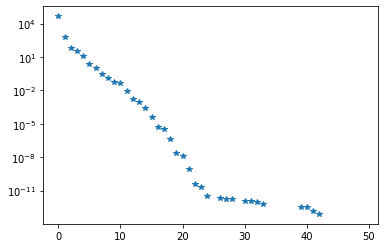

/home/i1000609/.local/lib/python3.6/site-packages/ipykernel_launcher.py:135: ComplexWarning: Casting complex values to real discards the imaginary part


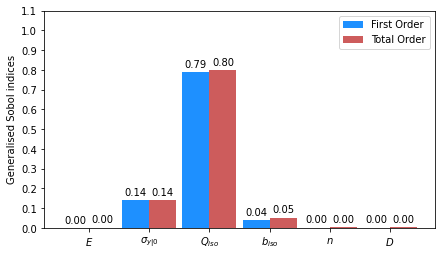

In [21]:
total_polynomial_degree = 5

# For monotonic loading, 
# set Q_kin and b_kin to 0
number_of_random_variables = 6 
polynomial_classes_of_random_variables = ['Legendre']*number_of_random_variables

# truncation level for KLE
n_kl = 3

KLE_modes_PCE = KLE_PCE_surrogate(  SampleSpace[:, 0:6], f_at_quad_points, quad_weights, total_polynomial_degree, 
                                    polynomial_classes_of_random_variables, n_kl, chaboche_uniform_isoprob_monotonic_transform)

KLE_modes_PCE.generalised_Sobol()